In [9]:
from typing import Any, List, Optional, Tuple, Union
import numpy as np
from magic_pen.config import DEVICE
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform
from segment_any_change.embedding import (
    compute_mask_embedding,
    get_img_embedding_normed,
)
from segment_any_change.masks.mask_items import (
    FilteringType,
    ImgType,
    ListProposal,
)
from segment_any_change.matching import (
    BitemporalMatching,
    neg_cosine_sim,
)
import torch
import torchvision
from torch.nn import functional as F
import kornia as K
from segment_any_change.model import BiSam
from segment_any_change.sa_dev_v0.predictor import SamPredictor
from torch.utils.data import DataLoader
from segment_any_change.utils import flush_memory, load_sam, to_degre, timeit, show_img
import matplotlib.pyplot as plt
from magic_pen.config import project_path
from magic_pen.utils_io import make_path
import os

import logging

# TO DO : define globally
logging.basicConfig(format="%(asctime)s - %(levelname)s ::  %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [10]:
from segment_any_change.eval import MetricEngine
from segment_any_change.masks.mask_process import extract_individual_object_from_mask, batched_mask_to_box

In [11]:
flush_memory()

In [12]:
sam_params = {
    "points_per_side": 10, #lower for speed
    "points_per_batch": 64, # not used
    "pred_iou_thresh": 0.88, # configure lower for exhaustivity
    "stability_score_thresh": 0.95, # configure lower for exhaustivity
    "stability_score_offset": 1.0,
    "box_nms_thresh": 0.7,
    "min_mask_region_area": 0,
}

## Inspect predictions

In [15]:
model_type="vit_b"
dir_name = f"predictions-{model_type}"
predictions_path = make_path(dir_name, project_path, "lightning_logs")

predictions = torch.load(os.path.join(predictions_path, 'predictions.pt'))

In [19]:
id_batch = 0

imgs = torch.sum(predictions[id_batch]["prediction"]["masks"], axis=1)
imgs = torchvision.utils.make_grid(imgs)

In [24]:
predictions[id_batch].keys()

dict_keys(['metrics', 'prediction', 'batch_idx'])

In [23]:
predictions[id_batch]["batch_idx"]

0

In [20]:
def show(imgs):
    if not isinstance(imgs, list) and not imgs.ndim > 2:
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(10, 10))
    for i, img in enumerate(imgs):
        img = img.to(torch.float).detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

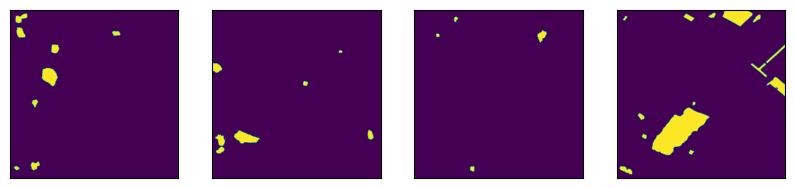

In [21]:
show(imgs)

## Run one batch

In [72]:
logger.info("==== start ====")

filter_change_proposals = "otsu"
batch_size=4
model_type="vit_b"

ds = BiTemporalDataset(
    name="levir-cd", 
    dtype="train", 
    transform=DefaultTransform()
)

sam = load_sam(
    model_type=model_type, 
    model_cls=BiSam,
    version="dev", 
    device=DEVICE
    )

matcher = BitemporalMatching(sam, filter_method=filter_change_proposals, **sam_params)

2024-05-30 14:31:02,344 - INFO ::  ==== start ====
2024-05-30 14:31:02,359 - INFO ::  build BiSam


In [12]:
print(len(BiTemporalDataset(
    name="levir-cd", 
    dtype="val", 
    transform=DefaultTransform()
)))
print(len(BiTemporalDataset(
    name="levir-cd", 
    dtype="test", 
    transform=DefaultTransform()
)))
print(len(BiTemporalDataset(
    name="levir-cd", 
    dtype="train", 
    transform=DefaultTransform()
)))

64
128
445


In [91]:
subset = torch.utils.data.Subset(ds, np.arange(10))


In [89]:
subset = torch.utils.data.SubsetRandomSampler(ds, [2])
dm = DataLoader(subset, batch_size=batch_size, shuffle=False, sampler=subset)


In [92]:
dm = DataLoader(subset, batch_size=batch_size, shuffle=False)


In [93]:
len(dm)

3

In [13]:
dataloader = DataLoader(ds, batch_size)

predictions = []

for i_batch, input_batch in enumerate(dataloader):
    predictions.append(matcher(batch=input_batch))
    if i_batch ==1:
        break

sparse_embeddings: torch.Size([8, 100, 2, 256])
dense_embeddings: torch.Size([8, 100, 256, 64, 64])

init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([8, 100, 5, 256])
tokens shape : torch.Size([8, 100, 7, 256])
img_embedding (src) : torch.Size([8, 100, 256, 64, 64])
--in transformer--
src : torch.Size([8, 100, 256, 64, 64])
pos_src : torch.Size([8, 100, 256, 64, 64])
tokens : torch.Size([8, 100, 7, 256])
- In transf src : torch.Size([8, 100, 4096, 256])
- In transf image_pe : torch.Size([8, 100, 4096, 256])
out transformer
hs shape : torch.Size([8, 100, 7, 256])
src shape : torch.Size([8, 100, 4096, 256])
iou out shape : torch.Size([8, 100, 256])
masks tokens out shape : torch.Size([8, 100, 4, 256])
upscaled src tokens out shape : torch.Size([8, 100, 32, 256, 256])
hyper in shape : torch.Size([8, 100, 4, 32])
 mask_low : torch.Size([8, 100, 4, 256, 256])
 filter iou_th : 42
 filter stability_score : 20
 filter mask_threshold : 20
 filter iou_th : 35
 filter sta

2024-05-30 13:27:55,924 - INFO ::  Function generate Took 32.6417 seconds


return 8


2024-05-30 13:27:56,238 - INFO ::  nan values ci 0
2024-05-30 13:27:56,239 - INFO ::  nan values ci1 0
2024-05-30 13:27:56,569 - INFO ::  Function proposal_matching Took 0.3296 seconds
2024-05-30 13:27:56,830 - INFO ::  nan values ci 1
2024-05-30 13:27:56,831 - INFO ::  nan values ci1 1
2024-05-30 13:27:57,076 - INFO ::  Function proposal_matching Took 0.2443 seconds
2024-05-30 13:27:57,307 - INFO ::  nan values ci 0
2024-05-30 13:27:57,308 - INFO ::  nan values ci1 0
2024-05-30 13:27:57,527 - INFO ::  Function proposal_matching Took 0.2178 seconds
2024-05-30 13:27:57,723 - INFO ::  nan values ci 0
2024-05-30 13:27:57,724 - INFO ::  nan values ci1 0
2024-05-30 13:27:57,888 - INFO ::  Function proposal_matching Took 0.1634 seconds
2024-05-30 13:27:57,927 - INFO ::  Function run Took 34.6448 seconds


sparse_embeddings: torch.Size([8, 100, 2, 256])
dense_embeddings: torch.Size([8, 100, 256, 64, 64])

init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([8, 100, 5, 256])
tokens shape : torch.Size([8, 100, 7, 256])
img_embedding (src) : torch.Size([8, 100, 256, 64, 64])
--in transformer--
src : torch.Size([8, 100, 256, 64, 64])
pos_src : torch.Size([8, 100, 256, 64, 64])
tokens : torch.Size([8, 100, 7, 256])
- In transf src : torch.Size([8, 100, 4096, 256])
- In transf image_pe : torch.Size([8, 100, 4096, 256])
out transformer
hs shape : torch.Size([8, 100, 7, 256])
src shape : torch.Size([8, 100, 4096, 256])
iou out shape : torch.Size([8, 100, 256])
masks tokens out shape : torch.Size([8, 100, 4, 256])
upscaled src tokens out shape : torch.Size([8, 100, 32, 256, 256])
hyper in shape : torch.Size([8, 100, 4, 32])
 mask_low : torch.Size([8, 100, 4, 256, 256])
 filter iou_th : 34
 filter stability_score : 17
 filter mask_threshold : 17
 filter iou_th : 41
 filter sta

2024-05-30 13:28:29,244 - INFO ::  Function generate Took 30.8370 seconds


return 8


2024-05-30 13:28:29,569 - INFO ::  nan values ci 1
2024-05-30 13:28:29,570 - INFO ::  nan values ci1 0
2024-05-30 13:28:29,919 - INFO ::  Function proposal_matching Took 0.3474 seconds
2024-05-30 13:28:29,999 - INFO ::  nan values ci 0
2024-05-30 13:28:30,000 - INFO ::  nan values ci1 0
2024-05-30 13:28:30,024 - INFO ::  Function proposal_matching Took 0.0229 seconds
2024-05-30 13:28:30,640 - INFO ::  nan values ci 0
2024-05-30 13:28:30,641 - INFO ::  nan values ci1 0
2024-05-30 13:28:31,995 - INFO ::  Function proposal_matching Took 1.3526 seconds
2024-05-30 13:28:32,182 - INFO ::  nan values ci 0
2024-05-30 13:28:32,183 - INFO ::  nan values ci1 0
2024-05-30 13:28:32,336 - INFO ::  Function proposal_matching Took 0.1530 seconds
2024-05-30 13:28:32,357 - INFO ::  Function run Took 33.9507 seconds


In [14]:
len(predictions)

2

In [18]:
print(predictions[0]["masks"].shape, predictions[0]["iou_preds"].shape)
print("--")
print(predictions[0]["iou_preds"])

torch.Size([4, 15, 1024, 1024]) torch.Size([4, 15])
--
tensor([[0.9638, 0.9316, 0.9299, 0.9205, 0.9167, 0.9079, 0.9058, 0.9031, 0.8842,
         0.9321, 0.9177, 0.9010, 0.8958, 0.0000, 0.0000],
        [0.9529, 0.9226, 0.9191, 0.9052, 0.8919, 0.8851, 0.9437, 0.9206, 0.9209,
         0.9146, 0.9037, 0.8975, 0.8956, 0.8948, 0.8816],
        [0.9153, 0.8825, 0.9187, 0.9111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9298, 0.9254, 0.9186, 0.9024, 0.9682, 0.9188, 0.9035, 0.8968, 0.8995,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


In [27]:
predictions[0]["masks"][-1].shape

torch.Size([15, 1024, 1024])

In [31]:
print(torch.sum(predictions[0]["masks"][0][-3]))
print(predictions[0]["iou_preds"][0][-3])
print("---")
print(torch.sum(predictions[0]["masks"][0][-2]))
print(predictions[0]["iou_preds"][0][-2])

tensor(607)
tensor(0.8958)
---
tensor(0)
tensor(0.)


In [ ]:
for img in predictions[0]["masks"]:
    print(torch.sum(img))

In [32]:
predictions[0]["masks"].shape

torch.Size([4, 15, 1024, 1024])

### Tests metrics builder

### Init

##### From group name

In [12]:
engine_eval = MetricEngine(metric_key="px_classif")

2024-05-29 11:59:15,906 - INFO ::  group metric
2024-05-29 11:59:15,908 - INFO ::  {'f1_score': <class 'torchmetrics.classification.f_beta.BinaryF1Score'>, 'precision': <class 'torchmetrics.classification.precision_recall.BinaryPrecision'>, 'recall': <class 'torchmetrics.classification.precision_recall.BinaryRecall'>}


In [13]:
engine_eval.engine["object"]._metrics

KeyError: 'object'

In [14]:
engine_eval.engine["pixel"]._metrics

MetricCollection(
  (BinaryF1Score): BinaryF1Score()
  (BinaryPrecision): BinaryPrecision()
  (BinaryRecall): BinaryRecall()
)

In [15]:
engine_eval.engine

{'pixel': <segment_any_change.eval.PxGroupMetric at 0x7f6998e67e20>}

##### From metrics names list

In [16]:
metrics = [
    {"name": "f1_score"},
    #{"name": "iou", "params": {"num_classes": 2}},
    {"name": "mAP"}
]
engine_eval = MetricEngine(in_metrics=metrics)

2024-05-29 11:59:33,257 - INFO ::  dispach metrics


In [19]:
engine_eval.engine

{'pixel': <segment_any_change.eval.PxGroupMetric at 0x7f6998e8ee00>,
 'object': <segment_any_change.eval.ObjGroupMetric at 0x7f64f40f1900>}

In [17]:
engine_eval.engine["pixel"]._metrics

MetricCollection(
  (BinaryF1Score): BinaryF1Score()
)

In [18]:
engine_eval.engine["object"]._metrics

MetricCollection(
  (MeanAveragePrecision): MeanAveragePrecision()
)

Ok ! Mais comment instantier le wrapper du group vide ? => None ?

##### Default

In [10]:
from segment_any_change.eval import get_px_metrics
from torchmetrics import MetricCollection

In [12]:
get_px_metrics()

[torchmetrics.classification.f_beta.BinaryF1Score,
 torchmetrics.classification.precision_recall.BinaryPrecision,
 torchmetrics.classification.precision_recall.BinaryRecall]

In [7]:
engine_eval = MetricEngine()

2024-05-29 12:06:52,656 - INFO ::  default run metric


In [8]:
engine_eval.engine

{'pixel': <segment_any_change.eval.PxGroupMetric at 0x7f60f7b34370>,
 'object': <segment_any_change.eval.ObjGroupMetric at 0x7f60f408e9e0>}

In [10]:
engine_eval.engine["pixel"]._metrics

MetricCollection(
  (BinaryF1Score): BinaryF1Score()
  (BinaryPrecision): BinaryPrecision()
  (BinaryRecall): BinaryRecall()
)

In [11]:
engine_eval.engine["object"]._metrics

MetricCollection(
  (MeanAveragePrecision): MeanAveragePrecision()
)

In [15]:
type(preds)

dict

### Run on batch

In [14]:
metrics = [
    {"name": "f1_score"},
    {"name": "iou", "params": {"num_classes": 2}},
    #{"name": "mAP"}
]
eval_engine = MetricEngine(metrics)
labels = input_batch["label"]
eval_engine.update(preds, labels)
m = eval_engine.compute()
m

2024-05-29 13:36:14,327 - INFO ::  dispach metrics


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [11]:
engine_eval.engine["object"]._metrics

NameError: name 'engine_eval' is not defined

In [ ]:
engine_eval.engine["pixel"]

In [18]:
isinstance(engine_eval._builder["object"], ObjMetricWrapper)

False

In [10]:
preds["iou_preds"].shape

torch.Size([2, 13])

In [ ]:
labels = input_batch["label"]
labels = extract_individual_object_from_mask(labels)
masks_boxes = batched_mask_to_box(preds.to(torch.bool))
labels_boxes = batched_mask_to_box(labels.to(torch.bool))

In [11]:
masks_boxes.shape

torch.Size([2, 13, 4])

In [12]:
labels_boxes.shape

torch.Size([2, 22, 4])

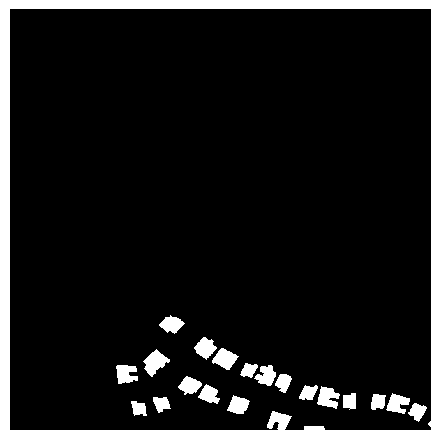

In [29]:
show_img(input_batch["label"][0,...].detach().cpu().numpy())

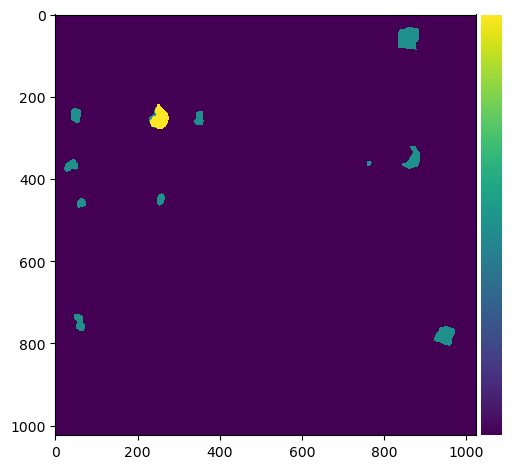

In [10]:
show_img(np.sum(preds[1].detach().cpu().numpy(), axis=0))

In [13]:
labels = input_batch["label"]
res = eval_mask_processing(preds, labels) 

In [14]:
res

[{'boxes': tensor([[ 362,  745,  424,  790],
          [ 447,  797,  503,  852],
          [ 490,  824,  555,  878],
          [ 324,  828,  389,  893],
          [ 560,  861,  603,  896],
          [ 259,  865,  311,  910],
          [ 594,  865,  646,  917],
          [ 644,  887,  685,  933],
          [ 408,  892,  468,  938],
          [ 702,  914,  749,  950],
          [ 457,  913,  510,  960],
          [ 746,  918,  801,  971],
          [ 809,  934,  841,  974],
          [ 877,  936,  913,  975],
          [ 346,  942,  390,  981],
          [ 529,  940,  582,  984],
          [ 915,  935,  972,  984],
          [ 295,  954,  332,  988],
          [ 968,  958, 1014, 1003],
          [1016, 1002, 1023, 1016],
          [ 624,  978,  684, 1023],
          [ 715, 1015,  764, 1023]]),
  'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 {'boxes': tensor([[216,   0, 265,  30],
          [626,   0, 674,  43],
          [73

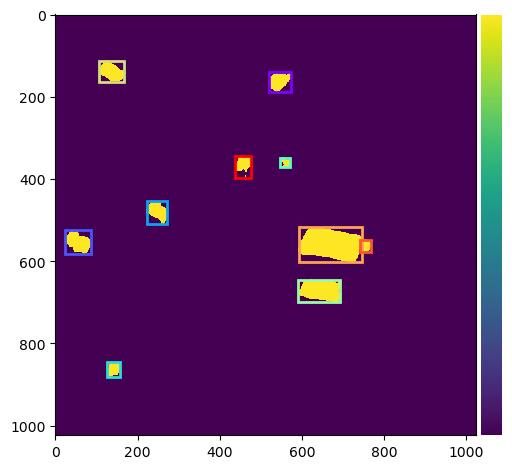

In [56]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

idx_item = 0

boxes = res_boxes.detach().cpu().numpy()[idx_item,...]
boxes = [((_[0], _[1]), (_[2] - _[0]), (_[3] - _[1])) for _ in boxes]

colors = plt.cm.rainbow(np.linspace(0, 1, len(boxes)))

fig, ax = plt.subplots()

#create simple line plot
#ax.plot()

show_img(np.sum(masks[idx_item].detach().cpu().numpy(), axis=0))
#ax = plt.gca()
for bbox,c in zip(boxes, colors):
    #add rectangle to plot
    ax.add_patch(Rectangle(*bbox,
                 edgecolor = c,
                 fill=False,
                 lw=2))

#ax.set_xlim([0, 1050])
#ax.set_ylim([0, 1050])

### to do
* revoir format torchmetrics
* combinaison metrics avec format different

* objects metrics : precision, recall based on iou

In [17]:
preds_ = preds.to(torch.int8)

In [26]:
preds.shape

torch.Size([2, 1024, 1024])

In [28]:
labels = input_batch["label"]
labels.shape

torch.Size([2, 1024, 1024])

In [20]:
preds_ = preds.long()

In [29]:
 labels = input_batch["label"]
preds = (preds > 1) * 1.
labels = (labels > 1) * 1.

preds_ = preds.long()
labels = labels.long()
preds_ = torch.nn.functional.one_hot(preds_, 2).permute(3, 0, 1, 2)
labels = torch.nn.functional.one_hot(labels, 2).permute(3, 0, 1, 2)


In [30]:
preds_.shape, labels.shape

(torch.Size([2, 2, 1024, 1024]), torch.Size([2, 2, 1024, 1024]))

In [15]:
from torchmetrics.classification import BinaryF1Score

logger.info("--- Bitemporal matching ---")
dataloader = DataLoader(ds, batch_size)

metrics = [
    {
        "name": "f1_score",
    }, 
    {
        "name": "iou",
        "params": {"num_classes": 2}
    }
]
#evaluator = CDEvaluator(metrics)
metric = MeanIoU(num_classes=2)
for i_batch, input_batch in enumerate(dataloader):
    preds = matcher(batch=input_batch, 
                    filter_method=filter_change_proposals)
    #labels = (input_batch["label"] > 0) * 1
    labels = input_batch["label"]
    preds = torch.sum(preds, dim=1)
    preds = (preds > 1) * 1.
    labels = (labels > 1) * 1.

    preds_ = preds.long()
    labels = labels.long()

    preds_ = torch.nn.functional.one_hot(preds_, 2).permute(3, 0, 1, 2)
    labels = torch.nn.functional.one_hot(labels, 2).permute(3, 0, 1, 2)
    #labels = extract_individual_object_from_mask(labels)

    #preds, labels = eval_mask_processing(preds, labels) 
    
    metric.update(preds, labels)    
    if i_batch == 0:
        break
m = metric.compute()

2024-05-28 09:58:42,372 - INFO ::  --- Bitemporal matching ---


NameError: name 'MeanIoU' is not defined

In [ ]:
l = [1, 2,  3]
list(dict(zip()))

In [14]:
preds["masks"].shape

torch.Size([2, 13, 1024, 1024])

In [20]:
preds_ = preds["masks"]
labels_ = input_batch["label"]
preds_ = (torch.sum(preds_, axis=1) > 1)*1
labels_ = (labels_ > 1)*1

In [23]:
torch.sum(preds_ * labels, axis=(1, 2))

tensor([0, 0])

In [29]:
np.sum(np.logical_and(preds_[1,...], labels[1,...]).detach().cpu().numpy())

0

In [38]:
from torchmetrics import Precision
preds_ = preds["masks"]
labels_ = input_batch["label"]
preds_ = (torch.sum(preds_, axis=1) > 1)*1
labels_ = (labels_ > 1)*1
preds_ = preds_.view(preds_.shape[0], -1)
labels_ = labels_.view(labels_.shape[0], -1)
precision = Precision(task="binary", average='micro', num_classes=2, top_k=1)
precision(preds_, labels_)

tensor(0.)

In [ ]:
from torchmetrics.classification import BinaryPrecision
preds_ = preds["masks"]
labels_ = input_batch["label"]
preds_ = (torch.sum(preds_, axis=1) > 1)*1
labels_ = (labels_ > 1)*1

precision = BinaryPrecision(threshold=0.5, multidim_average='samplewise')
precision(preds_, labels_)

In [11]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

logger.info("--- Bitemporal matching ---")
dataloader = DataLoader(ds, batch_size)

metric = MeanAveragePrecision(extended_summary=True)
for i_batch, input_batch in enumerate(dataloader):
    preds = matcher(batch=input_batch,
                    filter_method=filter_change_proposals)
    #labels = (input_batch["label"] > 0) * 1
    labels = input_batch["label"]
    preds_ = bbox_processing_factory(preds, "pred")
    labels_ = bbox_processing_factory(labels, "label")

    metric.update(preds_, labels_)    
    if i_batch == 0:
        break
m = metric.compute()

2024-05-28 17:46:17,864 - INFO ::  --- Bitemporal matching ---


sparse_embeddings: torch.Size([4, 100, 2, 256])
dense_embeddings: torch.Size([4, 100, 256, 64, 64])

init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([4, 100, 5, 256])
tokens shape : torch.Size([4, 100, 7, 256])
img_embedding (src) : torch.Size([4, 100, 256, 64, 64])
--in transformer--
src : torch.Size([4, 100, 256, 64, 64])
pos_src : torch.Size([4, 100, 256, 64, 64])
tokens : torch.Size([4, 100, 7, 256])
- In transf src : torch.Size([4, 100, 4096, 256])
- In transf image_pe : torch.Size([4, 100, 4096, 256])
out transformer
hs shape : torch.Size([4, 100, 7, 256])
src shape : torch.Size([4, 100, 4096, 256])
iou out shape : torch.Size([4, 100, 256])
masks tokens out shape : torch.Size([4, 100, 4, 256])
upscaled src tokens out shape : torch.Size([4, 100, 32, 256, 256])
hyper in shape : torch.Size([4, 100, 4, 32])
 mask_low : torch.Size([4, 100, 4, 256, 256])
 filter iou_th : 42
 filter stability_score : 20
 filter mask_threshold : 20
 filter iou_th : 35
 filter sta

2024-05-28 17:46:29,800 - INFO ::  Function generate Took 11.6059 seconds


return 4


2024-05-28 17:46:30,161 - INFO ::  nan values ci 0
2024-05-28 17:46:30,162 - INFO ::  nan values ci1 0
2024-05-28 17:46:30,500 - INFO ::  Function proposal_matching Took 0.3375 seconds
2024-05-28 17:46:30,794 - INFO ::  nan values ci 1
2024-05-28 17:46:30,795 - INFO ::  nan values ci1 1
2024-05-28 17:46:31,040 - INFO ::  Function proposal_matching Took 0.2437 seconds
2024-05-28 17:46:31,057 - INFO ::  Function run Took 12.8624 seconds


In [12]:
m

{'map': tensor(0.0111),
 'map_50': tensor(0.0167),
 'map_75': tensor(0.0149),
 'map_small': tensor(0.),
 'map_medium': tensor(0.0238),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.0159),
 'mar_10': tensor(0.0250),
 'mar_100': tensor(0.0250),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.0324),
 'mar_large': tensor(-1.),
 'ious': {(0,
   0): tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.000

#### MeanIou ok!

In [31]:
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import BinaryF1Score

logger.info("--- Bitemporal matching ---")
dataloader = DataLoader(ds, batch_size)

metric = MeanIoU(num_classes=2)
for i_batch, input_batch in enumerate(dataloader):
    preds = matcher(batch=input_batch, 
                    filter_method=filter_change_proposals)
    #labels = (input_batch["label"] > 0) * 1
    labels = input_batch["label"]
    preds = torch.sum(preds, dim=1)
    preds = (preds > 1) * 1.
    labels = (labels > 1) * 1.

    preds_ = preds.long()
    labels = labels.long()

    preds_ = torch.nn.functional.one_hot(preds_, 2).permute(3, 0, 1, 2)
    labels = torch.nn.functional.one_hot(labels, 2).permute(3, 0, 1, 2)
    #labels = extract_individual_object_from_mask(labels)

    #preds, labels = eval_mask_processing(preds, labels) 
    
    metric.update(preds_, labels)    
    if i_batch == 0:
        break
m = metric.compute()

2024-05-28 09:14:11,973 - INFO ::  --- Bitemporal matching ---


sparse_embeddings: torch.Size([4, 100, 2, 256])
dense_embeddings: torch.Size([4, 100, 256, 64, 64])

init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([4, 100, 5, 256])
tokens shape : torch.Size([4, 100, 7, 256])
img_embedding (src) : torch.Size([4, 100, 256, 64, 64])
--in transformer--
src : torch.Size([4, 100, 256, 64, 64])
pos_src : torch.Size([4, 100, 256, 64, 64])
tokens : torch.Size([4, 100, 7, 256])
- In transf src : torch.Size([4, 100, 4096, 256])
- In transf image_pe : torch.Size([4, 100, 4096, 256])
out transformer
hs shape : torch.Size([4, 100, 7, 256])
src shape : torch.Size([4, 100, 4096, 256])
iou out shape : torch.Size([4, 100, 256])
masks tokens out shape : torch.Size([4, 100, 4, 256])
upscaled src tokens out shape : torch.Size([4, 100, 32, 256, 256])
hyper in shape : torch.Size([4, 100, 4, 32])
 mask_low : torch.Size([4, 100, 4, 256, 256])
 filter iou_th : 42
 filter stability_score : 20
 filter mask_threshold : 20
 filter iou_th : 35
 filter sta

2024-05-28 09:14:23,380 - INFO ::  Function generate Took 11.1058 seconds


return 4
N masks A : 2
<class 'list'>


2024-05-28 09:14:23,724 - INFO ::  nan values ci 0
2024-05-28 09:14:23,725 - INFO ::  nan values ci1 0
2024-05-28 09:14:24,035 - INFO ::  Function proposal_matching Took 0.3090 seconds


<class 'list'>


2024-05-28 09:14:24,367 - INFO ::  nan values ci 1
2024-05-28 09:14:24,368 - INFO ::  nan values ci1 1
2024-05-28 09:14:24,603 - INFO ::  Function proposal_matching Took 0.2333 seconds
2024-05-28 09:14:24,614 - INFO ::  Function run Took 12.3402 seconds


In [32]:
m

tensor(0.4870)

In [ ]:
logger.info("--- Bitemporal matching ---")
for i_batch, batch in enumerate(dataloader):
    logger.info(f"Run batch {i_batch}")

    matcher(
    )
    print(f"Done : {len(items_change)}")
    break

In [9]:
logger.info("--- Bitemporal matching ---")
for i_batch, batch in enumerate(dataloader):
    logger.info(f"Run batch {i_batch}")

    items_change, th = matcher.run(
        batch=batch,
        filter_method=filter_change_proposals,
    )
    print(f"Done : {len(items_change)}")
    break

2024-05-24 15:27:02,790 - INFO ::  --- Bitemporal matching ---
2024-05-24 15:27:02,939 - INFO ::  Run batch 0


sparse_embeddings: torch.Size([2, 100, 2, 256])
dense_embeddings: torch.Size([2, 100, 256, 64, 64])

init tokens shape : torch.Size([5, 256])
inter tokens shape : torch.Size([2, 100, 5, 256])
tokens shape : torch.Size([2, 100, 7, 256])
img_embedding (src) : torch.Size([2, 100, 256, 64, 64])
--in transformer--
src : torch.Size([2, 100, 256, 64, 64])
pos_src : torch.Size([2, 100, 256, 64, 64])
tokens : torch.Size([2, 100, 7, 256])
- In transf src : torch.Size([2, 100, 4096, 256])
- In transf image_pe : torch.Size([2, 100, 4096, 256])
out transformer
hs shape : torch.Size([2, 100, 7, 256])
src shape : torch.Size([2, 100, 4096, 256])
iou out shape : torch.Size([2, 100, 256])
masks tokens out shape : torch.Size([2, 100, 4, 256])
upscaled src tokens out shape : torch.Size([2, 100, 32, 256, 256])
hyper in shape : torch.Size([2, 100, 4, 32])
 mask_low : torch.Size([2, 100, 4, 256, 256])
 filter iou_th : 42
 filter stability_score : 20
 filter mask_threshold : 20


2024-05-24 15:27:10,613 - INFO ::  Function generate Took 7.6722 seconds


 filter iou_th : 39
 filter stability_score : 11
 filter mask_threshold : 11


2024-05-24 15:27:10,816 - INFO ::  nan values ci 0
2024-05-24 15:27:10,817 - INFO ::  nan values ci1 0
2024-05-24 15:27:10,937 - INFO ::  Function proposal_matching Took 0.1192 seconds
2024-05-24 15:27:10,939 - INFO ::  Function run Took 7.9983 seconds


Done : 6


In [8]:
len(items_change)

NameError: name 'items_change' is not defined

In [11]:
masks = items_change.masks

In [9]:
preds.shape

torch.Size([4, 1024, 1024])

In [16]:
batch["label"].shape

torch.Size([1, 1024, 1024])

In [36]:
img_A = batch["img_A"].detach().numpy().squeeze().transpose(1, 2, 0)
img_B = batch["img_B"].detach().numpy().squeeze().transpose(1, 2, 0)
label = batch["label"].detach().numpy().squeeze()

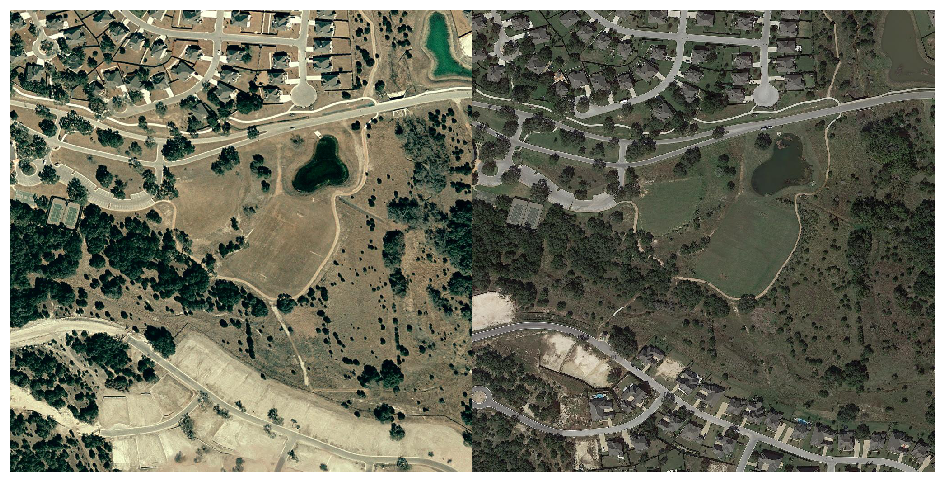

In [37]:
plt.figure(figsize=(10,10))
show_pair_img(img_A, img_B)

Text(0.5, 1.0, 'prediction - tout changements')

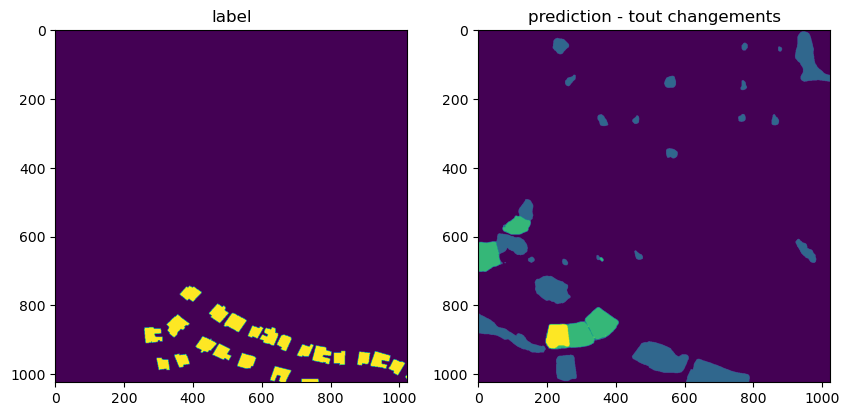

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(label)
axes[0].set_title("label")
axes[1].imshow(np.sum(masks, axis=0))
axes[1].set_title("prediction - tout changements")

In [7]:
A = np.arange(10)
A = np.expand_dims(A, axis=(1, 2))
A = np.repeat(A, 10, axis=2)
A = np.repeat(A, 10, axis=1)
A = torch.as_tensor(A)

In [8]:
A.shape

torch.Size([10, 10, 10])

In [9]:
A_ = A.view(A.shape[0]//2, -1, *A.shape[-2:])
A_.shape

torch.Size([5, 2, 10, 10])

In [10]:
A_[1, ...]

tensor([[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]],

        [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]]])

In [7]:
w = sam._modules["image_encoder"].neck[3].weight.shape
b = sam._modules["image_encoder"].neck[3].bias


In [ ]:
b[:,None, None].shape

In [ ]:
tmp.shape

In [ ]:
tmp = torch.tensor(np.ones((2, 256, 64, 64)))

In [ ]:
res = tmp - b[:, None, None]

In [6]:
evaluator = CDEvaluator(metrics)
evaluator.update(preds, input_batch["label"])
m = evaluator.compute()

NameError: name 'metrics' is not defined

In [ ]:
torch.max(preds[0])

In [23]:
torch.unique(preds[0,...])

tensor([0, 1, 2, 3], dtype=torch.int8)

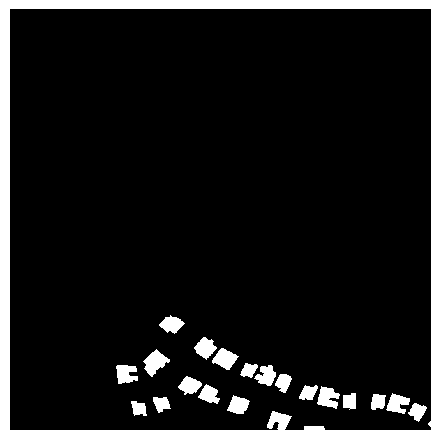

In [29]:
show_img(input_batch["label"][0,...].detach().cpu().numpy())

In [10]:
preds.dtype

torch.int8

In [12]:
torch.unique(input_batch["label"])

tensor([  0, 255], dtype=torch.uint8)

In [14]:
total_train_accuracy

tensor(0.9347)

In [21]:
from torchmetrics import MetricCollection, F1Score
from torchmetrics.detection.iou import IntersectionOverUnion

metrics = [F1Score(task="binary"), IntersectionOverUnion()]

m =  MetricCollection(metrics)

In [22]:
m

MetricCollection(
  (BinaryF1Score): BinaryF1Score()
  (IntersectionOverUnion): IntersectionOverUnion()
)

In [17]:
evaluator._metrics

MetricCollection
)

In [ ]:
metrics = [
    {
        "name": "f1_score", 
        "params": {"task": "binary"}
    }, 
    {
        "name": "iou"
    }
]
evaluator = CDEvaluator(metrics)


In [35]:
from segment_any_change.sa_dev.utils.amg import batched_mask_to_box

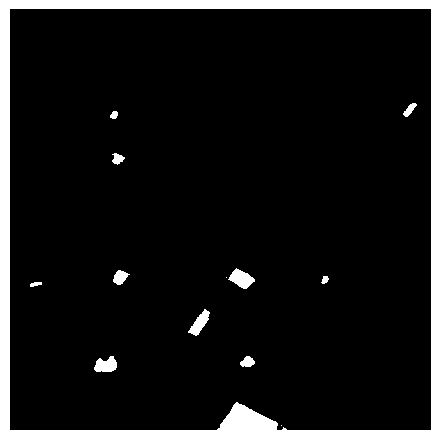

In [35]:
show_img(preds.to(torch.bool)[0,...].detach().cpu().numpy())

In [62]:
boxes = batched_mask_to_box(preds.to(torch.bool)) 

In [63]:
boxes.shape

torch.Size([2, 4])

In [64]:
boxes

tensor([[  48,  228,  988, 1023],
        [ 148,   51,  874,  267]])

In [14]:
preds.unsqueeze(1).shape

torch.Size([2, 1, 1024, 1024])

In [18]:
preds = preds.to(torch.float)

In [19]:
res = connected_components(preds.unsqueeze(1))

In [20]:
res.shape

torch.Size([2, 1, 1024, 1024])

In [21]:
print(torch.unique(res))


tensor([      0.,  268231.,  273662.,  387334.,  670222.,  683773.,  687371.,
         690234.,  697919.,  814534.,  891465.,  904427., 1038997., 1048156.,
        1048157., 1048158., 1048159., 1048160., 1048161., 1048162., 1048163.,
        1048164., 1048165., 1048166., 1048167., 1048168., 1048169., 1048170.,
        1048171., 1048172., 1048173., 1048174., 1048175., 1048176., 1048177.,
        1048178., 1048179., 1048180., 1048181., 1048182., 1048183., 1048184.,
        1048185., 1048186., 1048187., 1048188., 1048189., 1048190., 1048191.,
        1048192., 1048193., 1048194., 1048195., 1048196., 1048197., 1048198.,
        1048199., 1048200., 1048224., 1117342., 1322854.])


In [25]:
torch.unique(res[0, 0, :, :])

tensor([      0.,  268231.,  273662.,  387334.,  670222.,  683773.,  687371.,
         690234.,  697919.,  814534.,  891465.,  904427., 1038997., 1048156.,
        1048157., 1048158., 1048159., 1048160., 1048161., 1048162., 1048163.,
        1048164., 1048165., 1048166., 1048167., 1048168., 1048169., 1048170.,
        1048171., 1048172., 1048173., 1048174., 1048175., 1048176., 1048177.,
        1048178., 1048179., 1048180., 1048181., 1048182., 1048183., 1048184.,
        1048185., 1048186., 1048187., 1048188., 1048189., 1048190., 1048191.,
        1048192., 1048193., 1048194., 1048195., 1048196., 1048197., 1048198.,
        1048199., 1048200., 1048224.])

In [26]:
torch.unique(res[1, 0, :, :])

tensor([      0., 1117342., 1322854.])

* preds (List): A list consisting of dictionaries each containing the key-values (each dictionary corresponds to a single image). Parameters that should be provided per dict:

    * boxes (Tensor): float tensor of shape (num_boxes, 4) containing num_boxes detection boxes of the format specified in the constructor. By default, this method expects (xmin, ymin, xmax, ymax) in absolute image coordinates.

    * labels: IntTensor of shape (num_boxes) containing 0-indexed detection classes for the boxes.

In [40]:
import torch
import kornia as K
import torch.nn.functional as F
from torchvision.ops import boxes as box_ops

def extract_bounding_boxes_vectorized(masks: torch.Tensor) -> List[List[Tuple[int, int, int, int]]]:
    """
    Extract bounding boxes from binary masks using kornia's connected components in a vectorized manner.
    
    Args:
    masks (torch.Tensor): A tensor of shape (B, H, W) with binary masks.
    
    Returns:
    List[List[Tuple[int, int, int, int]]]: A list of bounding boxes for each mask in the batch.
                                           Each bounding box is represented as (x_min, y_min, x_max, y_max).
    """
    B, H, W = masks.shape

    # Add batch and channel dimensions to the masks (B, 1, H, W)
    masks = masks.unsqueeze(1).float()

    # Compute connected components
    labels = K.contrib.connected_components(masks)

    # Reshape labels for processing
    labels = labels.view(B, H, W)

    # Compute unique labels and create a mask for each
    unique_labels = labels.unique(dim=(1, 2))  # Unique labels per mask
    max_label = unique_labels.max().item() + 1

    # One-hot encode the labels across the batch
    one_hot = F.one_hot(labels.long(), num_classes=max_label).permute(0, 3, 1, 2).float()

    # Find bounding boxes for each component in a vectorized manner
    bounding_boxes = []

    for i in range(1, max_label):  # Skipping background label 0
        mask = one_hot[:, i]  # Mask for the current label
        if mask.sum() == 0:
            continue

        y_indices, x_indices = torch.nonzero(mask, as_tuple=True)[1:]
        x_min = x_indices.min(dim=0).values
        x_max = x_indices.max(dim=0).values
        y_min = y_indices.min(dim=0).values
        y_max = y_indices.max(dim=0).values

        for j in range(B):
            if (mask[j].sum() > 0).item():
                bounding_boxes.append((x_min[j].item(), y_min[j].item(), x_max[j].item(), y_max[j].item()))

    return bounding_boxes

In [56]:
res.shape

torch.Size([2, 1, 1024, 1024])

In [58]:
torch.unique(res.squeeze(1), dim=res.shape[0]).shape

torch.Size([2, 1024, 328])

In [52]:
F.one_hot(res.long(), num_classes=(torch.unique(res, dim=res.shape[-1]).shape[1]-1))

IndexError: Dimension out of range (expected to be in range of [-4, 3], but got 1024)

In [51]:
torch.unique(res).shape

torch.Size([61])

In [46]:
res.unique(dim=1)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [41]:
preds.shape

torch.Size([2, 1024, 1024])

In [42]:
res = extract_bounding_boxes_vectorized(preds)

TypeError: unique_dim(): argument 'dim' (position 2) must be int, not tuple

In [59]:
from typing import Any, List, Dict, Union
import torch
from torchmetrics import MetricCollection
from torchmetrics.segmentation import MeanIoU
from torchmetrics.detection import MeanAveragePrecision
from torchmetrics.classification import (
    BinaryF1Score, 
    BinaryAccuracy, 
    BinaryAveragePrecision, 
    BinaryPrecision, 
    BinaryRecall
)

def find_register_group(d, key):
    if key in d:
        return d[key]
    for k, v in d.items():
        if isinstance(v, dict):
            result = find_register_group(v, key)
            if result:
                return result
    return {}

_metrics_registry = {
    "pixel":{
        "classif":{
            "f1_score":BinaryF1Score(),
            "precision":BinaryPrecision(),
            "recall":BinaryRecall(),
        },
        "segmentation":{
            "iou": MeanIoU(num_classes=2) # how to instantiate it
        }
    },
    "object":{
        "segmentation":{
            "mAP": MeanAveragePrecision(extended_summary=True) # extended_summary=True return Precision, Recall, IoU
        }
    }

}

print(find_register_group(_metrics_registry, "classif"))
print('---')
def paths(tree, cur=()):
    if not isinstance(tree, dict):
        yield cur
    else:
        for n, s in tree.items():
            for path in paths(s, cur+(n,)):
                yield path
                
list(paths(_metrics_registry))

def get_root(tree, key):
    for p in paths(tree):
        if key in p:
            return p

def get_root_group_registry(key: str, registry: Dict=_metrics_registry) -> str:
    """return group name from metric registry from nested key"""
    def paths(tree: Dict, cur=()):
        if not isinstance(tree, dict):
            yield cur
        else:
            for n, s in tree.items():
                for path in paths(s, cur+(n,)):
                    yield path
    
    for p in paths(registry):
        if key in p:
            return p[0]
        
            
print(get_root(_metrics_registry, "f1_score"))
print("----")
print(find_register_group(_metrics_registry, "object"))
print('---')
print(get_root_group_registry("iou"))
print('---')

{'f1_score': BinaryF1Score(), 'precision': BinaryPrecision(), 'recall': BinaryRecall()}
---
('pixel', 'classif', 'f1_score')
----
{'segmentation': {'mAP': MeanAveragePrecision()}}
---
pixel
---
